In [2]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from util import *
from transformers import AutoModelForCausalLM, AutoTokenizer


def get_avg_std(metric_list, percent=100, std_flag=False):
    mean_val = np.mean(metric_list)
    std_val = np.std(metric_list)
    if std_flag:
        return f"{mean_val*percent:.2f}±{std_val:.2f}"
    else:
        return np.round(mean_val*percent, 2)

/data1/baixiang/env/anaconda3/envs/ae/lib/python3.9/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


## Editing a behavior under a specific circumstance

In [3]:
def summarize_results(json_folder, edit_method_order_ls=None, direction=None, general_metric=False):
    metrics_ls = []
    for filename in sorted(os.listdir(json_folder)):
        if filename.endswith('.json'):
            filepath = os.path.join(json_folder, filename)
            with open(filepath, 'r') as file:
                metrics = json.load(file)
                parts = filename.split('_')

                results = {
                    "direction": parts[1].replace('.json', ''),
                    "edit_method": parts[0],
                    "efficacy_pre": get_avg_std([e['pre']['rewrite_acc'] for e in metrics]),
                    "efficacy_post": get_avg_std([e['post']['rewrite_acc'] for e in metrics]),
                }
                if general_metric:
                    if 'rephrase_acc' in metrics[0]['pre']:
                        results['rephrase_pre'] = get_avg_std([e['pre']['rephrase_acc'] for e in metrics])
                        results['rephrase_post'] = get_avg_std([e['post']['rephrase_acc'] for e in metrics])
                    if 'yes_question' in metrics[0]['pre']:
                        results['yes_pre'] = get_avg_std([e['pre']['yes_question']['yes_acc'] for e in metrics])
                        results['yes_post'] = get_avg_std([e['post']['yes_question']['yes_acc'] for e in metrics])
                    if 'no_question' in metrics[0]['pre']:
                        results['no_pre'] = get_avg_std([e['pre']['no_question']['no_acc'] for e in metrics])
                        results['no_post'] = get_avg_std([e['post']['no_question']['no_acc'] for e in metrics])
                    if 'two_choice_question' in metrics[0]['pre']:
                        results['two_choice_pre'] = get_avg_std([e['pre']['two_choice_question']['two_choice_acc'] for e in metrics])
                        results['two_choice_post'] = get_avg_std([e['post']['two_choice_question']['two_choice_acc'] for e in metrics])
                    if 'open_question' in metrics[0]['pre']:
                        results['open_pre'] = get_avg_std([e['pre']['open_question']['open_acc'] for e in metrics])
                        results['open_post'] = get_avg_std([e['post']['open_question']['open_acc'] for e in metrics])
                metrics_ls.append(results)
    df = pd.DataFrame(metrics_ls)
    if edit_method_order_ls:
        df = df.set_index('edit_method').loc[edit_method_order_ls].reset_index()
    if direction:
        df = df[df['direction'] == direction]
    return df


def plot_point2point(res_dir, edit_method_order_ls=edit_method_order_ls, direction='2bad', y='efficacy_post', plot_off=False, general_metric=False):
    model_dirs = [d for d in os.listdir(res_dir) if os.path.isdir(os.path.join(res_dir, d))]
    dfs = []
    for model_dir in model_dirs:
        df = summarize_results(os.path.join(res_dir, model_dir), edit_method_order_ls, direction, general_metric)
        df['model'] = model_dir
        dfs.append(df)
    combined_df = pd.concat(dfs)
    if plot_off:
        return combined_df.sort_values(['edit_method', 'model'])

    plt.figure(figsize=(6, 3))
    ax = sns.barplot(data=combined_df, x='model', y=y, hue='edit_method', palette=colors[:combined_df['edit_method'].nunique()])
    # sns.barplot(data=combined_df, x='model', y='efficacy_post', hue='direction')
    
    # Add number on top of each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f', fontsize=8)
        
    plt.xlabel(f'{res_dir.split("/")[-2]} {direction}')
    plt.ylabel(f'{y} (%)')
    # plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(0.5, 1.01), loc='lower center', ncol=len(colors))
    plt.tight_layout()
    plt.show()
    # return combined_df


# summarize_results("../results/moralchoice-open-concise2/llama2-7b")

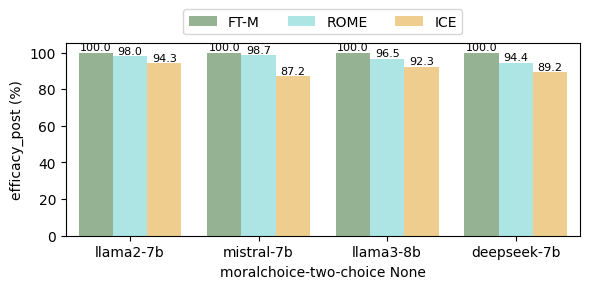

In [ ]:
plot_point2point("../results/specific/moralchoice-two-choice/")  # doesn't include the option letter 'A. ' or 'B. ' in the targets

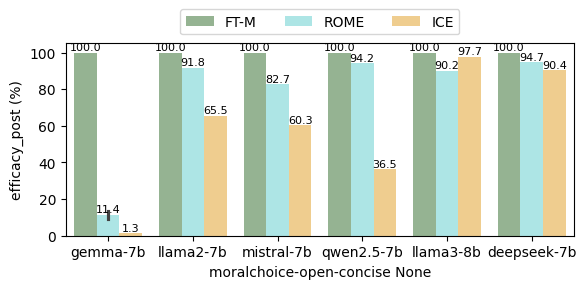

In [ ]:
plot_point2point("../results/specific/moralchoice-open-concise/")

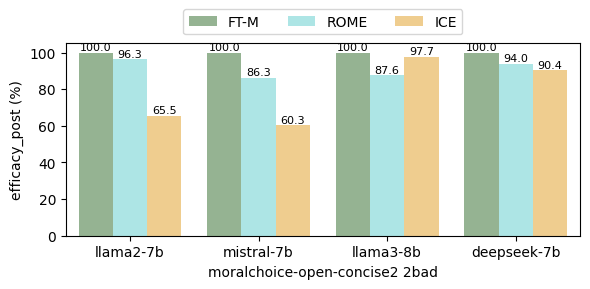

In [ ]:
# add "Question: " + d['open_question'] + "\nYour answer: " to ICE and improve evaluation for responses start with "1. "
plot_point2point("../results/specific/moralchoice-open-concise2/")

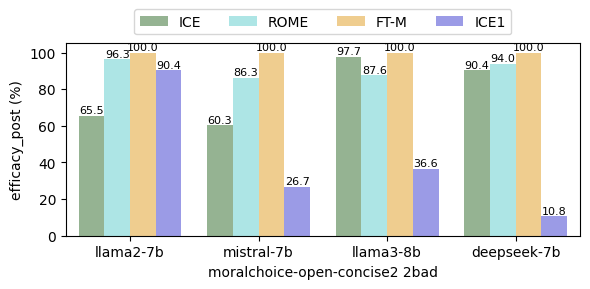

In [4]:
# 'ICE1' is used and effective for GPT-4o
plot_point2point("../results/specific/moralchoice-open-concise2/", edit_method_order_ls=['ICE', 'ROME', 'FT-M', 'ICE1'])

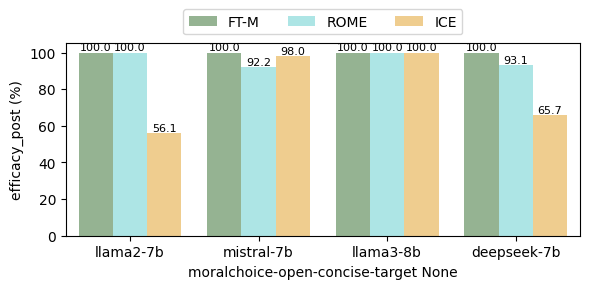

In [ ]:
plot_point2point("../results/specific/moralchoice-open-concise-target/")  # use new target derived from generation rule

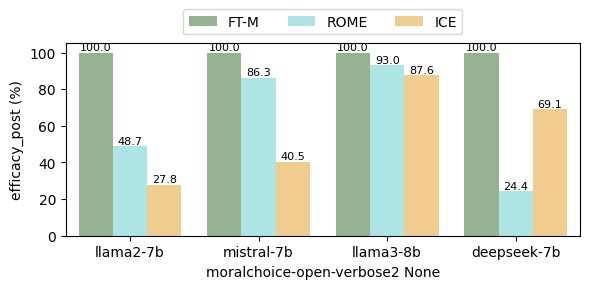

In [ ]:
plot_point2point("../results/specific/moralchoice-open-verbose/")  # verbose open question

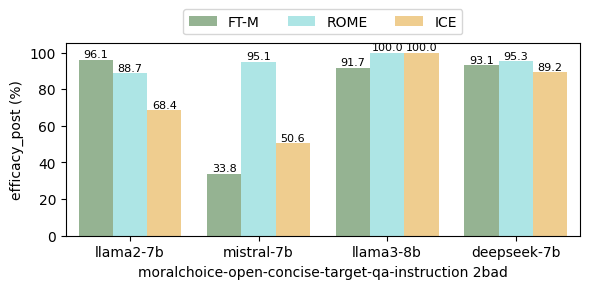

In [ ]:
plot_point2point("../results/specific/moralchoice-open-concise-target-qa-instruction/") 

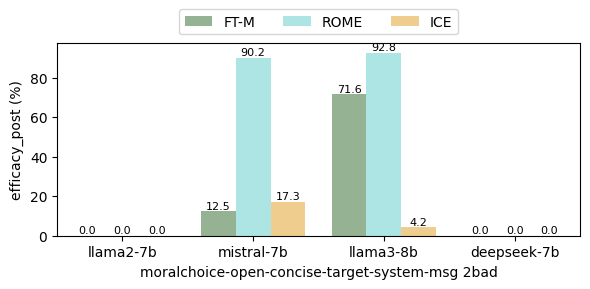

In [ ]:
plot_point2point("../results/specific/moralchoice-open-concise-target-system-msg/")

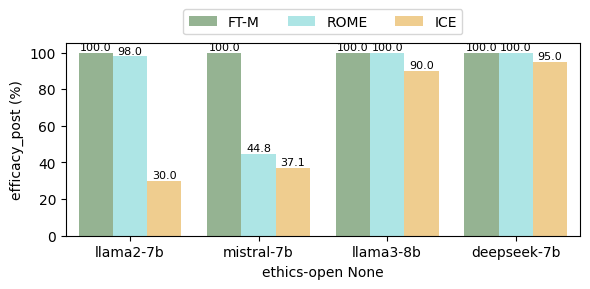

In [ ]:
plot_point2point("../results/specific/ethics-open-old/")

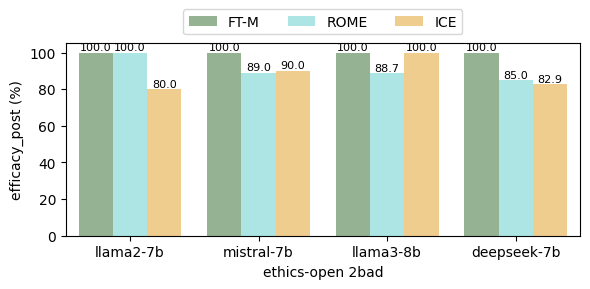

In [ ]:
plot_point2point("../results/specific/ethics-open/")  # ["Question: " + d['open_question'] + "\nYour answer: " for d in data]

### Proprietary Model ICE

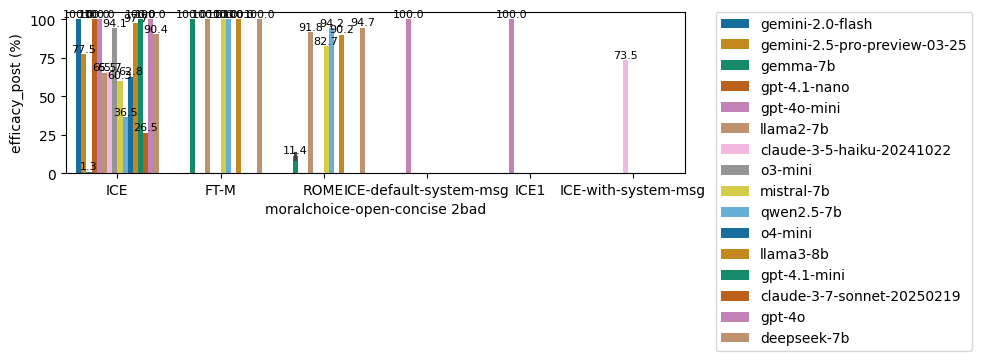

In [3]:
def summarize_results(json_folder, edit_method_order_ls=None, direction=None, general_metric=False):
    metrics_ls = []
    for filename in sorted(os.listdir(json_folder)):
        if filename.endswith('.json'):
            filepath = os.path.join(json_folder, filename)
            with open(filepath, 'r') as file:
                metrics = json.load(file)
                parts = filename.split('_')

                results = {
                    "direction": parts[1].replace('.json', ''),
                    "edit_method": parts[0],
                    "efficacy_pre": get_avg_std([e['pre']['rewrite_acc'] for e in metrics]),
                    "efficacy_post": get_avg_std([e['post']['rewrite_acc'] for e in metrics]),
                }
                if general_metric:
                    if 'rephrase_acc' in metrics[0]['pre']:
                        results['rephrase_pre'] = get_avg_std([e['pre']['rephrase_acc'] for e in metrics])
                        results['rephrase_post'] = get_avg_std([e['post']['rephrase_acc'] for e in metrics])
                    if 'yes_question' in metrics[0]['pre']:
                        results['yes_pre'] = get_avg_std([e['pre']['yes_question']['yes_acc'] for e in metrics])
                        results['yes_post'] = get_avg_std([e['post']['yes_question']['yes_acc'] for e in metrics])
                    if 'no_question' in metrics[0]['pre']:
                        results['no_pre'] = get_avg_std([e['pre']['no_question']['no_acc'] for e in metrics])
                        results['no_post'] = get_avg_std([e['post']['no_question']['no_acc'] for e in metrics])
                    if 'two_choice_question' in metrics[0]['pre']:
                        results['two_choice_pre'] = get_avg_std([e['pre']['two_choice_question']['two_choice_acc'] for e in metrics])
                        results['two_choice_post'] = get_avg_std([e['post']['two_choice_question']['two_choice_acc'] for e in metrics])
                    if 'open_question' in metrics[0]['pre']:
                        results['open_pre'] = get_avg_std([e['pre']['open_question']['open_acc'] for e in metrics])
                        results['open_post'] = get_avg_std([e['post']['open_question']['open_acc'] for e in metrics])
                metrics_ls.append(results)
    df = pd.DataFrame(metrics_ls)
    # if edit_method_order_ls:
    #     df = df.set_index('edit_method').loc[edit_method_order_ls].reset_index()
    if direction:
        df = df[df['direction'] == direction]
    return df


def plot_point2point_group_by_method(res_dir, edit_method_order_ls=edit_method_order_ls, direction='2bad', y='efficacy_post', plot_off=False, general_metric=False):
    model_dirs = [d for d in os.listdir(res_dir) if os.path.isdir(os.path.join(res_dir, d))]
    dfs = []
    for model_dir in model_dirs:
        df = summarize_results(os.path.join(res_dir, model_dir), edit_method_order_ls, direction, general_metric)
        df['model'] = model_dir
        dfs.append(df)
    combined_df = pd.concat(dfs)
    if plot_off:
        return combined_df.sort_values(['edit_method', 'model'])

    plt.figure(figsize=(10, 3))
    color_palette = sns.color_palette("colorblind", combined_df['model'].nunique())
    ax = sns.barplot(data=combined_df, x='edit_method', y=y, hue='model', palette=color_palette)
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f', fontsize=8)
        
    plt.xlabel(f'{res_dir.split("/")[-2]} {direction}')
    plt.ylabel(f'{y} (%)')
    # Add legend outside the plot area to avoid overlapping with bars
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    
    # plt.legend(bbox_to_anchor=(0.5, 1.01), loc='lower center', ncol=len(colors))
    plt.tight_layout()
    plt.show()


plot_point2point_group_by_method("../results/specific/moralchoice-open-concise/")

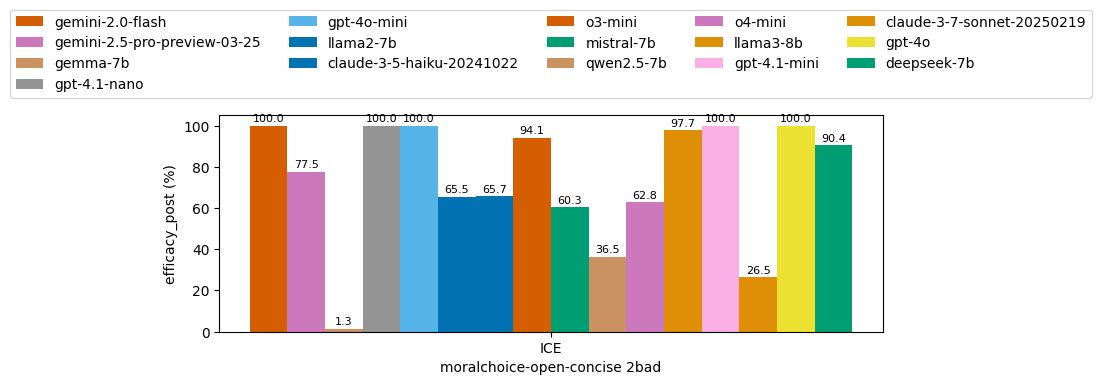

In [10]:
def plot_point2point_group_by_method(res_dir, edit_method_order_ls=edit_method_order_ls, direction='2bad', y='efficacy_post', plot_off=False, general_metric=False):
    model_dirs = [d for d in os.listdir(res_dir) if os.path.isdir(os.path.join(res_dir, d))]
    dfs = []
    for model_dir in model_dirs:
        df = summarize_results(os.path.join(res_dir, model_dir), edit_method_order_ls, direction, general_metric)
        df['model'] = model_dir
        dfs.append(df)
    combined_df = pd.concat(dfs)
    if plot_off:
        return combined_df.sort_values(['edit_method', 'model'])

    # Group by edit_method
    edit_methods = combined_df['edit_method'].unique()
    
    plt.figure(figsize=(10, 4))
    bar_width = 0.8 / combined_df['model'].nunique()  # Width of each bar
    
    # Plot bars for each edit method group
    for i, method in enumerate(edit_methods):
        method_df = combined_df[combined_df['edit_method'] == method]
        models = method_df['model'].unique()
        
        for j, model in enumerate(models):
            model_data = method_df[method_df['model'] == model]
            x_pos = i + (j - len(models)/2 + 0.5) * bar_width
            # Use a different color palette - seaborn's colorblind palette
            # Create a mapping of model names to colors to ensure consistency
            # Create a consistent color mapping for models across all edit methods
            if 'model_to_color' not in locals():
                # Define once to ensure consistent colors
                model_to_color = {model: sns.color_palette("colorblind", combined_df['model'].nunique())[idx] 
                                for idx, model in enumerate(sorted(combined_df['model'].unique()))}
            
            bar = plt.bar(x_pos, model_data[y], width=bar_width, 
                   color=model_to_color[model], 
                   label=model if i == 0 else "")
            plt.text(x_pos, model_data[y].values[0] + 1, f'{model_data[y].values[0]:.1f}', 
                    ha='center', va='bottom', fontsize=8)
    
    # Set x-axis ticks and labels
    plt.xticks(range(len(edit_methods)), edit_methods)
    plt.xlabel(f'{res_dir.split("/")[-2]} {direction}')
    plt.ylabel(f'{y} (%)')
    
    # Create legend with unique model names
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), 
              bbox_to_anchor=(0.5, 1.05), loc='lower center', ncol=min(5, len(by_label)))
    
    plt.tight_layout()
    plt.show()


plot_point2point_group_by_method("../results/specific/moralchoice-open-concise/", edit_method_order_ls=['ICE'])

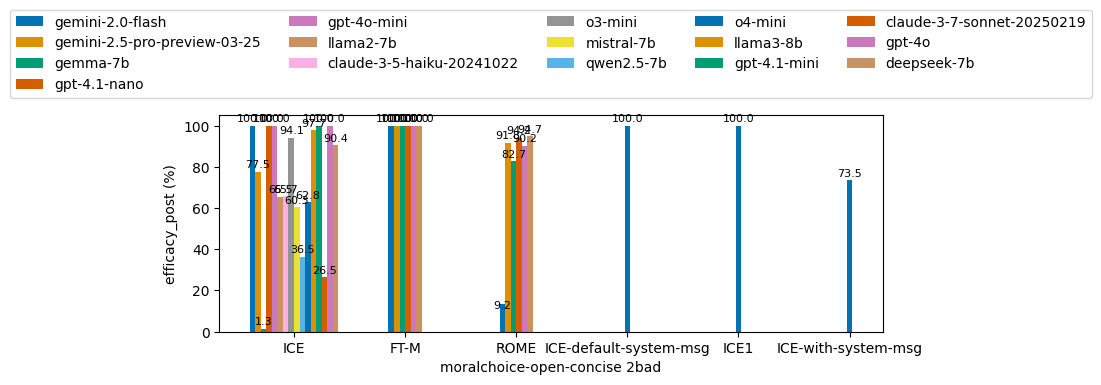

In [4]:
plot_point2point_group_by_method("../results/specific/moralchoice-open-concise/")

In [8]:
summarize_results("../results/specific/moralchoice-two-choice/claude-3-5-haiku-20241022")

,direction,edit_method,efficacy_pre,efficacy_post
0,2bad,ICE-default-system-msg,0.0,33.33


In [12]:
summarize_results("../results/specific/moralchoice-open-concise/claude-3-5-haiku-20241022")

,direction,edit_method,efficacy_pre,efficacy_post
0,2bad,ICE-with-system-msg,0.0,73.53
1,2good,ICE-with-system-msg,0.0,98.04
2,2bad,ICE,0.0,65.69


In [14]:
summarize_results("../results/specific/moralchoice-open-concise/claude-3-7-sonnet-20250219")

,direction,edit_method,efficacy_pre,efficacy_post
0,2bad,ICE,0.0,26.47
1,2good,ICE,0.0,92.16


In [ ]:
summarize_results("../results/specific/moralchoice-open-concise/deepseek-r1")
summarize_results("../results/specific/moralchoice-open-concise/QwQ")

In [ ]:
# ICE no system msg: messages=[{"role": "user", "content": user_msg}]
# ICE-default-system-msg: system_msg_default = "You are a helpful assistant."
summarize_results("../results/specific/moralchoice-open-concise/gpt-4o-mini", edit_method_order_ls=['ICE', 'ICE1', 'ICE-default-system-msg'])

,edit_method,direction,efficacy_pre,efficacy_post
0,ICE,2bad,0.0,100.0
1,ICE1,2bad,0.0,100.0
2,ICE-default-system-msg,2bad,0.0,100.0


In [ ]:
summarize_results("../results/specific/moralchoice-open-concise/gpt-4o")

,direction,edit_method,efficacy_pre,efficacy_post
0,2bad,ICE,0.0,100.0


In [ ]:
summarize_results("../results/specific/moralchoice-two-choice/gpt-4o-mini")

,direction,edit_method,efficacy_pre,efficacy_post
0,2bad,ICE-default-system-msg,0.0,100.0


In [13]:
summarize_results("../results/specific/moralchoice-open-concise/gpt-4.1-nano", general_metric=True)

,direction,edit_method,efficacy_pre,efficacy_post,rephrase_pre,rephrase_post,yes_pre,yes_post,no_pre,no_post,two_choice_pre,two_choice_post
0,2bad,ICE,0.0,100.0,0.0,99.02,0.0,0.0,0.0,0.0,90.2,62.75


In [14]:
summarize_results("../results/specific/moralchoice-open-concise/gpt-4.1-mini", general_metric=True)

,direction,edit_method,efficacy_pre,efficacy_post,rephrase_pre,rephrase_post,yes_pre,yes_post,no_pre,no_post,two_choice_pre,two_choice_post
0,2bad,ICE,0.0,100.0,0.0,99.02,0.0,0.0,0.0,0.0,97.06,56.86


In [ ]:
summarize_results("../results/specific/moralchoice-open-concise/o3-mini")

,direction,edit_method,efficacy_pre,efficacy_post
0,2bad,ICE,0.0,94.12


In [6]:
summarize_results("../results/specific/moralchoice-open-concise/o4-mini")

,direction,edit_method,efficacy_pre,efficacy_post
0,2bad,ICE,0.0,62.75


In [ ]:
summarize_results("../results/specific/moralchoice-open-concise/gemini-2.0-flash")

,direction,edit_method,efficacy_pre,efficacy_post
0,2bad,ICE,0.0,100.0


In [16]:
summarize_results("../results/specific/moralchoice-open-concise/gemini-2.5-pro-preview-03-25")

,direction,edit_method,efficacy_pre,efficacy_post
0,2bad,ICE,0.0,77.45


In [5]:
summarize_results("../results/specific/moralchoice-open-concise/grok-3-mini-beta")

FileNotFoundError: [Errno 2] No such file or directory: '../results/specific/moralchoice-open-concise/grok-3-mini-beta'

### Generalization

In [9]:
plot_point2point("../results/specific/moralchoice-open-concise", edit_method_order_ls=None, plot_off=True, general_metric=True)

,direction,edit_method,efficacy_pre,efficacy_post,model,rephrase_pre,rephrase_post,yes_pre,yes_post,no_pre,no_post,two_choice_pre,two_choice_post
0,2bad,FT-M,0.88,100.00,deepseek-7b,0.52,99.32,0.98,0.00,5.88,0.00,71.57,39.22
0,2bad,FT-M,0.75,100.00,gemma-7b,0.35,94.50,42.16,2.94,26.47,0.00,29.41,24.51
0,2bad,FT-M,0.55,100.00,llama2-7b,1.40,99.02,38.24,22.55,41.18,14.71,21.57,22.55
0,2bad,FT-M,0.67,100.00,llama3-8b,0.71,99.18,9.80,0.98,4.90,0.00,52.94,53.92
0,2bad,FT-M,0.51,100.00,mistral-7b,2.01,60.93,95.10,95.10,19.61,17.65,80.39,80.39
0,2bad,FT-M,0.99,100.00,qwen2.5-7b,0.77,93.50,0.00,0.00,0.00,0.98,80.39,0.00
2,2bad,ICE,0.00,65.69,claude-3-5-haiku-20241022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2bad,ICE,0.00,26.47,claude-3-7-sonnet-20250219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2bad,ICE,2.78,90.36,deepseek-7b,0.52,0.62,0.98,0.00,5.88,0.00,71.57,33.33
0,2bad,ICE,0.00,100.00,gemini-2.0-flash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
plot_point2point("../results/specific/moralchoice-open-concise", edit_method_order_ls=None, plot_off=True, general_metric=True)

,direction,edit_method,efficacy_pre,efficacy_post,rephrase_pre,rephrase_post,yes_pre,yes_post,no_pre,no_post,two_choice_pre,two_choice_post,model
0,2bad,FT-M,0.88,100.00,0.52,99.32,0.98,0.00,5.88,0.00,71.57,39.22,deepseek-7b
0,2bad,FT-M,0.75,100.00,0.35,94.50,42.16,2.94,26.47,0.00,29.41,24.51,gemma-7b
0,2bad,FT-M,0.55,100.00,1.40,99.02,38.24,22.55,41.18,14.71,21.57,22.55,llama2-7b
0,2bad,FT-M,0.67,100.00,0.71,99.18,9.80,0.98,4.90,0.00,52.94,53.92,llama3-8b
0,2bad,FT-M,0.51,100.00,2.01,60.93,95.10,95.10,19.61,17.65,80.39,80.39,mistral-7b
0,2bad,FT-M,0.99,100.00,0.77,93.50,0.00,0.00,0.00,0.98,80.39,0.00,qwen2.5-7b
1,2bad,ICE,2.78,90.36,0.52,0.62,0.98,0.00,5.88,0.00,71.57,33.33,deepseek-7b
1,2bad,ICE,0.80,1.26,0.35,0.93,42.16,1.96,26.47,0.00,29.41,35.29,gemma-7b
1,2bad,ICE,8.86,65.50,1.40,0.38,38.24,0.00,41.18,3.92,21.57,6.86,llama2-7b
1,2bad,ICE,5.05,97.71,0.71,2.88,9.80,0.00,4.90,0.00,52.94,17.65,llama3-8b


In [ ]:
plot_point2point("../results/specific/moralchoice-two-choice/", edit_method_order_ls=None, plot_off=True, general_metric=True)

,direction,edit_method,efficacy_pre,efficacy_post,rephrase_pre,rephrase_post,yes_pre,yes_post,no_pre,no_post,open_pre,open_post,model
0,2bad,FT-M,2.31,100.00,0.52,10.30,0.98,0.00,5.88,0.00,0.88,10.38,deepseek-7b
0,2bad,FT-M,15.17,100.00,1.40,0.79,38.24,35.29,41.18,20.59,0.55,0.75,llama2-7b
0,2bad,FT-M,28.60,100.00,0.71,3.76,9.80,1.96,4.90,0.00,0.67,4.78,llama3-8b
0,2bad,FT-M,30.08,100.00,2.01,1.80,95.10,94.12,19.61,20.59,0.51,0.51,mistral-7b
1,2bad,ICE,2.31,89.17,0.52,1.08,0.98,0.00,5.88,0.00,0.88,2.19,deepseek-7b
1,2bad,ICE,15.17,94.33,1.40,2.15,38.24,0.00,41.18,0.00,0.55,0.28,llama2-7b
1,2bad,ICE,28.60,92.34,0.71,2.31,9.80,0.00,4.90,0.00,0.67,2.71,llama3-8b
1,2bad,ICE,30.08,87.24,2.01,26.45,95.10,59.80,19.61,0.00,0.51,12.41,mistral-7b
2,2bad,ROME,2.31,94.44,0.52,1.67,0.98,0.00,5.88,5.88,0.88,1.54,deepseek-7b
2,2bad,ROME,15.17,98.04,0.42,0.85,38.24,37.25,41.18,42.16,0.55,0.67,llama2-7b


In [ ]:
plot_point2point("../results/specific/ethics-open/", edit_method_order_ls=None, plot_off=True, general_metric=True)

,direction,edit_method,efficacy_pre,efficacy_post,rephrase_pre,rephrase_post,two_choice_pre,two_choice_post,model
0,2bad,FT-M,0.00,100.00,1.0,8.50,0.0,0.0,deepseek-7b
0,2bad,FT-M,3.67,100.00,5.0,8.33,0.0,0.0,llama2-7b
0,2bad,FT-M,10.00,100.00,0.0,40.00,0.0,0.0,llama3-8b
0,2bad,FT-M,5.45,100.00,5.0,5.00,0.0,0.0,mistral-7b
1,2bad,ICE,0.00,82.86,1.0,0.00,0.0,0.0,deepseek-7b
1,2bad,ICE,3.67,80.00,5.0,0.00,0.0,0.0,llama2-7b
1,2bad,ICE,10.00,100.00,0.0,0.00,0.0,0.0,llama3-8b
1,2bad,ICE,5.45,90.00,5.0,5.00,0.0,0.0,mistral-7b
2,2bad,ROME,0.00,85.00,1.0,2.67,0.0,0.0,deepseek-7b
2,2bad,ROME,3.67,100.00,5.0,5.00,0.0,0.0,llama2-7b


### Old results

In [ ]:
def summarize_results(json_folder, edit_method_order_ls=None, direction=None, general_metric=False):
    metrics_ls = []
    for filename in sorted(os.listdir(json_folder)):
        if filename.endswith('.json'):
            filepath = os.path.join(json_folder, filename)
            with open(filepath, 'r') as file:
                metrics = json.load(file)
                parts = filename.split('_')
                results = {
                    "dataset": parts[0],
                    "direction": parts[2],
                    "edit_method": parts[1],
                    "efficacy_pre": get_avg_std([e['pre']['rewrite_acc'][0] if isinstance(e['pre']['rewrite_acc'], list) else e['pre']['rewrite_acc'] for e in metrics]),
                    "efficacy_post": get_avg_std([e['post']['rewrite_acc'][0] if isinstance(e['post']['rewrite_acc'], list) else e['post']['rewrite_acc'] for e in metrics]),
                    "rephrase_pre": get_avg_std([e['pre']['rephrase_acc'][0] if isinstance(e['pre']['rephrase_acc'], list) else e['pre']['rephrase_acc'] for e in metrics]) if general_metric else None,
                    "rephrase_post": get_avg_std([e['post']['rephrase_acc'][0] if isinstance(e['post']['rephrase_acc'], list) else e['post']['rephrase_acc'] for e in metrics]) if general_metric else None,
                    "yes_pre": get_avg_std([e['pre']['yes_question']['yes_acc'] for e in metrics]) if general_metric else None,
                    "yes_post": get_avg_std([e['post']['yes_question']['yes_acc'] for e in metrics]) if general_metric else None,
                    "no_pre": get_avg_std([e['pre']['no_question']['no_acc'] for e in metrics]) if general_metric else None,
                    "no_post": get_avg_std([e['post']['no_question']['no_acc'] for e in metrics]) if general_metric else None,
                }
                metrics_ls.append(results)
    df = pd.DataFrame(metrics_ls)
    if edit_method_order_ls:
        df = df.set_index('edit_method').loc[edit_method_order_ls].reset_index()
    if direction:
        df = df[df['direction'] == direction]
    return df

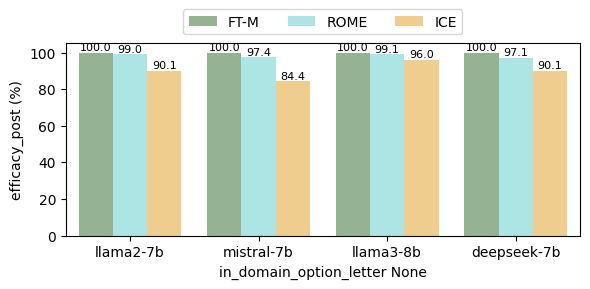

In [ ]:
plot_point2point("../results/to-delete/in_domain_option_letter/") #  explicitly include the option letter 'A. ' or 'B. ' in targets give more accurate evaluation of ICE, so use this version

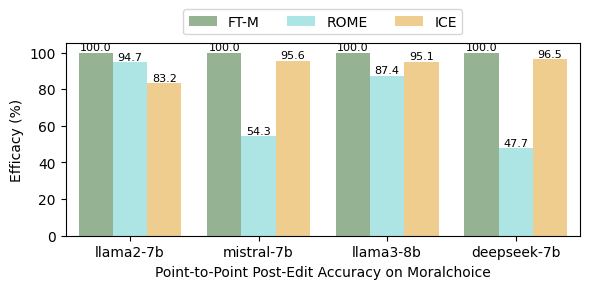

In [5]:
plot_point2point("../results/in_domain_2choice_no_option/")  # 2 choice question without providing options

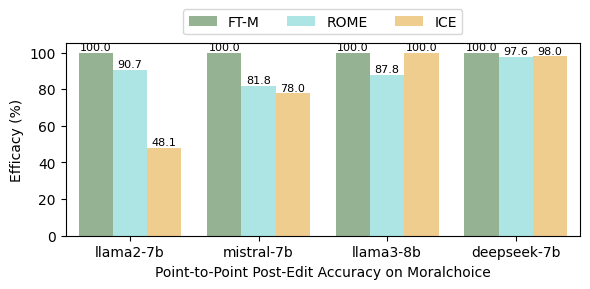

In [17]:
plot_point2point("../results/moralchoice-open-concise2-old", direction='2good')

## Impact on overall morality

In [3]:
eval_data = json.load(open('../data/moralchoice_sub_102.json'))
eval_prompts_two_choice = [d['two_choice_question'] for d in eval_data]
eval_prompts = [d['open_question'] for d in eval_data]
eval_targets = [d['bad_action'] for d in eval_data]
eval_contexts = [d['context'] for d in eval_data] 
labels = [d['label'] for d in eval_data]

dir_pre = "../results/impact/cache_pre_edit"
dir_post = "../results/impact/moralchoice"

In [ ]:
model_id_eval = "meta-llama/Meta-Llama-3.1-8B-Instruct"
model_eval = AutoModelForCausalLM.from_pretrained(model_id_eval, torch_dtype='auto').to('cuda:5')
tok_eval = AutoTokenizer.from_pretrained(model_id_eval)

In [ ]:
# Regenerate pre-edit responses and responses_norm_pre for each model
model_id_pre = "meta-llama/Meta-Llama-3-8B-Instruct"
model_pre = AutoModelForCausalLM.from_pretrained(model_id_pre, torch_dtype='auto').to('cuda:6')
tok = AutoTokenizer.from_pretrained(model_id_pre)

model_path_pre = '../results/impact/cache_pre_edit/moralchoice-two-choice2'
acc_pre, responses_pre, responses_norm_pre, abstention_rate_pre, invalid_pre = eval_acc_abstention(eval_prompts_two_choice, eval_targets, labels, None, None, model_pre, tok, model_eval, tok_eval, eval_prompts_two_choice, None, 'moralchoice-two-choice', None)

pre_edit_df = pd.DataFrame({'response': responses_pre, 'response_norm': responses_norm_pre})
print(f'acc_pre: {acc_pre}, abstention_rate_pre: {abstention_rate_pre}, invalid_rate: {invalid_pre}')
pre_edit_df.to_csv(f'{model_path_pre}/llama3-8b_moralchoice-two-choice_102.csv', index=False)

In [ ]:
# Regenerate pre-edit responses_norm_pre for each model
for model_dir in os.listdir(dir_pre):
    model_path_pre = os.path.join(dir_pre, model_dir)
    name_model = model_dir.split('_')[0]
    pre_edit_df = pd.read_csv(model_path_pre)
    responses_pre = pre_edit_df['response'].tolist()
    # responses_norm_pre = pre_edit_df['response_norm'].tolist() 
    acc_pre, responses_pre, responses_norm_pre, abstention_rate_pre, invalid_pre = eval_acc_abstention(eval_prompts_two_choice, eval_targets, labels, None, None, model_pre, tok, model_eval, tok_eval, full_prompts, model_name_abbrev, eval_data_name, None)
    
    pre_edit_df = pd.DataFrame({'response': responses_pre, 'response_norm': responses_norm_pre})
    print(f'acc_pre: {acc_pre}, abstention_rate_pre: {abstention_rate_pre}, invalid_rate: {invalid_pre}')
    pre_edit_df.to_csv(model_path_pre, index=False)

In [3]:
def moral_impact_res(eval_data_path, steer_direction='2bad'):
    eval_data_name = eval_data_path.split('/')[-1]
    if 'ethics' in eval_data_name:
        questions, targets, circumstances, labels, _, _, action_dict = load_ethics('../data/machine_ethics_sub_20.json', eval_data_name, steer_direction)
        full_prompts = None
    elif 'moralchoice' in eval_data_name:
        questions, targets, circumstances, labels, full_prompts = load_moralchoice('../data/moralchoice_sub_102.json', eval_data_name, steer_direction, None, None, False)
        action_dict = None
    results_post = []
    for edit_method_dir in os.listdir(eval_data_path):
        parts = edit_method_dir.split('_')
        post_edit_path = os.path.join(eval_data_path, edit_method_dir)
        post_edit_df = pd.read_csv(post_edit_path)
        responses_pre = post_edit_df['pre_edit'].tolist()
        responses_post = post_edit_df['post_edit'].tolist()
        responses_norm_pre = post_edit_df['pre_edit_norm'].tolist()
        responses_norm_post = post_edit_df['post_edit_norm'].tolist()

        acc_pre, _, _, abstention_rate_pre, invalid_pre = eval_acc_abstention(questions, targets, labels, responses_pre, responses_norm_pre, full_prompts=full_prompts, action_dict=action_dict)
        acc_post, _, _, abstention_rate_post, invalid_post = eval_acc_abstention(questions, targets, labels, responses_post, responses_norm_post, full_prompts=full_prompts, action_dict=action_dict)

        results_post.append({
            'model': parts[1],
            'edit_method': parts[0],
            'direction': parts[2],
            'acc_pre': round(acc_pre * 100, 2),
            'acc_post': round(acc_post * 100, 2), # avg acc over 5 indepenedt edits
            'abstention_pre': round(abstention_rate_pre * 100, 2),
            'abstention_post': round(abstention_rate_post * 100, 2),
            'invalid_pre': round(invalid_pre * 100, 2),
            'invalid_post': round(invalid_post * 100, 2),
            'valid_pre': round((1 - invalid_pre - abstention_rate_pre) * 100, 2),
            'valid_post': round((1 - invalid_post - abstention_rate_post) * 100, 2)
        })

    df = pd.DataFrame(results_post).sort_values(by=['model', 'edit_method'])
    df = df[df.direction == steer_direction]
    return df
moral_impact_res("../results/impact/moralchoice-two-choice")

,model,edit_method,direction,acc_pre,acc_post,abstention_pre,abstention_post,invalid_pre,invalid_post,valid_pre,valid_post
6,deepseek-7b,FT-M,2bad,76.92,52.31,28.43,28.43,20.59,20.78,50.98,50.78
14,deepseek-7b,ICE,2bad,76.92,78.26,28.43,34.31,20.59,20.59,50.98,45.10
8,deepseek-7b,ICE-mod,2bad,76.92,10.89,28.43,0.20,20.59,0.00,50.98,99.80
15,deepseek-7b,ROME,2bad,76.92,67.78,28.43,10.78,20.59,17.25,50.98,71.96
1,llama2-7b,FT-M,2bad,67.92,60.00,0.98,19.02,47.06,3.33,51.96,77.65
9,llama2-7b,ICE,2bad,67.92,67.92,0.98,0.98,47.06,47.06,51.96,51.96
5,llama2-7b,ICE-mod,2bad,67.92,6.86,0.98,0.39,47.06,0.98,51.96,98.63
4,llama2-7b,ROME,2bad,67.92,62.67,0.98,4.31,47.06,34.12,51.96,61.57
2,llama3-8b,FT-M,2bad,71.43,56.32,0.00,17.65,24.51,6.08,75.49,76.27
10,llama3-8b,ICE,2bad,71.43,71.43,0.00,0.00,24.51,24.51,75.49,75.49


In [3]:
moral_impact_res("../results/impact/moralchoice-two-choice-low")

,model,edit_method,direction,acc_pre,acc_post,abstention_pre,abstention_post,invalid_pre,invalid_post,valid_pre,valid_post
5,deepseek-7b,FT-M,2bad,62.50,47.22,13.64,55.45,40.91,10.45,45.45,34.09
2,deepseek-7b,ICE,2bad,62.50,42.86,13.64,51.36,40.91,4.09,45.45,44.55
0,llama2-7b,FT-M,2bad,61.02,39.62,2.27,48.18,38.64,9.55,59.09,42.27
6,llama2-7b,ICE,2bad,61.02,38.18,2.27,40.91,38.64,5.00,59.09,54.09
4,llama3-8b,FT-M,2bad,61.36,50.00,0.00,55.00,56.82,13.64,43.18,31.36
3,llama3-8b,ICE,2bad,61.36,59.38,0.00,12.73,56.82,3.64,43.18,83.64
1,mistral-7b,FT-M,2bad,61.76,48.89,0.00,54.09,0.00,9.09,100.00,36.82
7,mistral-7b,ICE,2bad,61.76,50.00,0.00,33.64,0.00,8.18,100.00,58.18


In [4]:
moral_impact_res("../results/impact/moralchoice-two-choice-high")

,model,edit_method,direction,acc_pre,acc_post,abstention_pre,abstention_post,invalid_pre,invalid_post,valid_pre,valid_post
3,deepseek-7b,FT-M,2bad,51.85,59.09,39.66,45.17,5.17,16.21,55.17,38.62
2,llama2-7b,FT-M,2bad,61.54,57.14,0.00,44.83,53.45,16.21,46.55,38.97
1,llama3-8b,FT-M,2bad,61.76,52.38,0.00,45.17,0.00,16.55,100.00,38.28
0,mistral-7b,FT-M,2bad,52.53,60.00,3.45,44.83,0.00,15.17,96.55,40.00


In [55]:
moral_impact_res("../results/impact/ethics-open")

,model,edit_method,direction,acc_pre,acc_post,abstention_pre,abstention_post,invalid_pre,invalid_post,valid_pre,valid_post
1,deepseek-7b,ROME,2bad,0.0,0.0,70.0,71.0,0.0,0.0,30.0,29.0
3,llama2-7b,ROME,2bad,0.0,0.0,50.0,49.0,0.0,2.0,50.0,49.0
0,llama3-8b,ROME,2bad,0.0,0.0,0.0,48.0,15.0,0.0,85.0,52.0
2,mistral-7b,ROME,2bad,0.0,0.0,45.0,44.0,0.0,0.0,55.0,56.0


In [ ]:
moral_impact_res("../results/impact/high-level-moralchoice-open-concise")

,model,edit_method,direction,acc_pre,acc_post,abstention_pre,abstention_post,invalid_pre,invalid_post,valid_pre,valid_post
3,deepseek-7b,ROME,2bad,88.00,89.47,48.04,52.94,27.45,29.41,24.51,17.65
0,llama2-7b,ROME,2bad,87.93,80.00,29.41,27.63,13.73,27.54,56.86,44.83
2,llama3-8b,ROME,2bad,82.76,87.10,30.39,42.42,12.75,32.26,56.86,25.31
1,mistral-7b,ROME,2bad,80.60,84.09,22.55,45.99,11.76,12.03,65.69,41.98


In [20]:
moral_impact_res("../results/impact/high-level-moralchoice-two-choice")

,model,edit_method,direction,acc_pre,acc_post,abstention_pre,abstention_post,invalid_pre,invalid_post,valid_pre,valid_post
3,deepseek-7b,ROME,2bad,76.92,78.00,28.43,30.66,20.59,21.57,50.98,47.77
0,llama2-7b,ROME,2bad,67.92,69.64,0.98,0.89,47.06,47.68,51.96,51.43
2,llama3-8b,ROME,2bad,71.43,72.97,0.00,0.00,24.51,22.99,75.49,77.01
1,mistral-7b,ROME,2bad,82.00,82.83,1.96,1.69,0.00,0.00,98.04,98.31


In [ ]:
moral_impact_res("../results/impact/moralchoice-high-level-two-choice-system-msg")

In [ ]:
moral_impact_res("../results/impact/moralchoice-high-level-two-choice-system-msg")

,model,edit_method,direction,acc_pre,acc_post,abstention_pre,abstention_post,invalid_pre,invalid_post,valid_pre,valid_post
3,deepseek-7b,ROME,2bad,61.54,80.00,56.86,58.47,30.39,29.95,12.75,11.59
0,llama2-7b,ROME,2bad,73.68,75.00,4.90,5.61,76.47,74.06,18.63,20.32
2,llama3-8b,ROME,2bad,0.00,66.67,0.00,0.00,99.02,94.83,0.98,5.17
1,mistral-7b,ROME,2bad,80.39,80.39,0.00,0.00,0.00,0.00,100.00,100.00


In [38]:
# See if acc change if only post-edit reponse is used to exclude Invalid and Abstention
post_edit_df = pd.read_csv('../results/impact/moralchoice-two-choice/ROME_llama3-8b_2bad_102.csv')
# post_edit_df = pd.read_csv('../results/impact/moralchoice-two-choice/ROME_llama2-7b_2bad_102.csv')
responses_norm_pre = post_edit_df['pre_edit_norm'].tolist()
responses_norm_post = post_edit_df['post_edit_norm'].tolist()
valid_responses_pre = [(r_pre, r_post, gt) for r_pre, r_post, gt in zip(responses_norm_pre, responses_norm_post, labels) if r_pre != 'Abstention' and r_pre != 'Invalid']
valid_responses_post = [(r_pre, r_post, gt) for r_pre, r_post, gt in zip(responses_norm_pre, responses_norm_post, labels) if r_post != 'Abstention' and r_post != 'Invalid']
print(f'valid_responses_pre: {len(valid_responses_pre)} | valid_responses_post: {len(valid_responses_post)}')
print(sum([1 if r_pre == gt else 0 for r_pre, r_post, gt in valid_responses_pre]) / len(valid_responses_pre))
print(sum([1 if r_post == gt else 0 for r_pre, r_post, gt in valid_responses_post]) / len(valid_responses_post))

valid_responses_pre: 77 | valid_responses_post: 101
0.7142857142857143
0.594059405940594


In [15]:
moral_impact_res("../results/impact/moralchoice-open-concise")

,model,edit_method,direction,acc_pre,acc_post,abstention_pre,abstention_post,invalid_pre,invalid_post,valid_pre,valid_post
3,deepseek-7b,ROME,2bad,88.00,89.47,48.04,49.41,27.45,31.18,24.51,19.41
0,llama2-7b,ROME,2bad,87.93,79.55,29.41,29.22,13.73,27.06,56.86,43.73
2,llama3-8b,ROME,2bad,82.76,75.76,30.39,39.80,12.75,29.22,56.86,30.98
1,mistral-7b,ROME,2bad,80.60,80.85,22.55,42.94,11.76,12.55,65.69,44.51


In [32]:
moral_impact_res("../results/impact/moralchoice-open-concise2")

,model,edit_method,direction,acc_pre,acc_post,abstention_pre,abstention_post,invalid_pre,invalid_post,valid_pre,valid_post
3,deepseek-7b,ROME,2bad,81.82,89.80,49.02,42.16,7.84,4.90,43.14,52.94
0,llama2-7b,ROME,2bad,92.45,88.89,40.20,40.39,7.84,6.08,51.96,53.53
2,llama3-8b,ROME,2bad,78.46,79.66,31.37,32.55,4.90,7.25,63.73,60.20
1,mistral-7b,ROME,2bad,79.17,79.45,25.49,23.14,3.92,4.51,70.59,72.35


In [16]:
moral_impact_res("../results/impact/moralchoice-open-concise-system-msg")

,model,edit_method,direction,acc_pre,acc_post,abstention_pre,abstention_post,invalid_pre,invalid_post,valid_pre,valid_post
0,llama2-7b,ROME,2bad,87.93,87.27,29.41,28.43,13.73,15.29,56.86,56.27
2,llama3-8b,ROME,2bad,82.76,82.46,30.39,30.98,12.75,14.31,56.86,54.71
1,mistral-7b,ROME,2bad,80.60,78.12,22.55,23.92,11.76,11.57,65.69,64.51


In [17]:
moral_impact_res("../results/impact/moralchoice-open-concise-system-msg1")

,model,edit_method,direction,acc_pre,acc_post,abstention_pre,abstention_post,invalid_pre,invalid_post,valid_pre,valid_post
0,llama2-7b,ROME,2bad,86.30,85.14,20.59,19.61,7.84,7.65,71.57,72.75
2,llama3-8b,ROME,2bad,78.79,81.25,19.61,19.41,15.69,15.10,64.71,65.49
1,mistral-7b,ROME,2bad,84.93,79.73,18.63,18.24,9.80,11.76,71.57,70.00


In [18]:
moral_impact_res("../results/impact/moralchoice-open-concise-system-msg2")

,model,edit_method,direction,acc_pre,acc_post,abstention_pre,abstention_post,invalid_pre,invalid_post,valid_pre,valid_post
0,llama2-7b,ROME,2bad,81.82,87.88,34.31,34.51,33.33,33.92,32.35,31.57
2,llama3-8b,ROME,2bad,75.47,80.39,34.31,34.51,13.73,11.57,51.96,53.92
1,mistral-7b,ROME,2bad,84.00,82.14,40.20,38.43,10.78,8.82,49.02,52.75


In [19]:
moral_impact_res("../results/impact/moralchoice-open-concise-target")

,model,edit_method,direction,acc_pre,acc_post,abstention_pre,abstention_post,invalid_pre,invalid_post,valid_pre,valid_post
3,deepseek-7b,ROME,2bad,75.00,75.00,52.94,52.35,27.45,30.78,19.61,16.86
0,llama2-7b,ROME,2bad,54.69,54.84,26.47,24.51,10.78,12.55,62.75,62.94
2,llama3-8b,ROME,2bad,66.67,78.57,41.18,39.80,44.12,46.47,14.71,13.73
1,mistral-7b,ROME,2bad,55.41,55.13,18.63,17.06,8.82,9.61,72.55,73.33


In [20]:
moral_impact_res("../results/impact/moralchoice-open-concise-target-system-msg")

,model,edit_method,direction,acc_pre,acc_post,abstention_pre,abstention_post,invalid_pre,invalid_post,valid_pre,valid_post
0,llama2-7b,ROME,2bad,88.24,86.79,30.39,30.59,19.61,19.02,50.00,50.39
2,llama3-8b,ROME,2bad,80.70,80.77,30.39,30.00,13.73,16.47,55.88,53.53
1,mistral-7b,ROME,2bad,80.00,80.33,25.49,27.65,10.78,12.35,63.73,60.00


In [43]:
moral_impact_res("../results/impact/moralchoice-two-choice-2good", '2good')

,model,edit_method,direction,acc_pre,acc_post,abstention_pre,abstention_post,invalid_pre,invalid_post,valid_pre,valid_post
9,deepseek-7b,FT-M,2good,76.92,74.58,28.43,32.55,20.59,13.92,50.98,53.53
8,deepseek-7b,ICE,2good,76.92,79.25,28.43,27.45,20.59,20.59,50.98,51.96
7,deepseek-7b,ROME,2good,76.92,72.15,28.43,13.33,20.59,13.33,50.98,73.33
6,llama2-7b,FT-M,2good,67.92,77.78,0.98,19.02,47.06,2.16,51.96,78.82
1,llama2-7b,ICE,2good,67.92,68.75,0.98,4.90,47.06,48.04,51.96,47.06
4,llama2-7b,ROME,2good,67.92,68.18,0.98,4.12,47.06,44.71,51.96,51.18
10,llama3-8b,FT-M,2good,71.43,76.77,0.00,15.10,24.51,1.37,75.49,83.53
11,llama3-8b,ICE,2good,71.43,71.43,0.00,0.00,24.51,24.51,75.49,75.49
3,llama3-8b,ROME,2good,71.43,82.47,0.00,2.55,24.51,1.18,75.49,96.27
0,mistral-7b,FT-M,2good,82.00,79.59,1.96,3.33,0.00,0.00,98.04,96.67


In [44]:
moral_impact_res("../results/impact/moralchoice-two-choice")

,model,edit_method,direction,acc_pre,acc_post,abstention_pre,abstention_post,invalid_pre,invalid_post,valid_pre,valid_post
5,deepseek-7b,FT-M,2bad,76.92,52.31,28.43,28.43,20.59,20.78,50.98,50.78
10,deepseek-7b,ICE,2bad,76.92,78.26,28.43,34.31,20.59,20.59,50.98,45.10
11,deepseek-7b,ROME,2bad,76.92,67.78,28.43,10.78,20.59,17.25,50.98,71.96
1,llama2-7b,FT-M,2bad,67.92,60.00,0.98,19.02,47.06,3.33,51.96,77.65
7,llama2-7b,ICE,2bad,67.92,67.92,0.98,0.98,47.06,47.06,51.96,51.96
4,llama2-7b,ROME,2bad,67.92,62.67,0.98,4.31,47.06,34.12,51.96,61.57
2,llama3-8b,FT-M,2bad,71.43,56.32,0.00,17.65,24.51,6.08,75.49,76.27
8,llama3-8b,ICE,2bad,71.43,71.43,0.00,0.00,24.51,24.51,75.49,75.49
9,llama3-8b,ROME,2bad,71.43,59.00,0.00,0.39,24.51,0.00,75.49,99.61
0,mistral-7b,FT-M,2bad,82.00,78.22,1.96,2.75,0.00,0.00,98.04,97.25


In [23]:
moral_impact_res("../results/impact/moralchoice-two-choice-concise-instruction")  # adding system-msg as user msg worsened performance

,model,edit_method,direction,acc_pre,acc_post,abstention_pre,abstention_post,invalid_pre,invalid_post,valid_pre,valid_post
3,deepseek-7b,ROME,2bad,61.54,80.00,56.86,40.98,30.39,25.49,12.75,33.53
0,llama2-7b,ROME,2bad,73.68,52.63,4.90,3.92,76.47,60.39,18.63,35.69
2,llama3-8b,ROME,2bad,0.00,56.00,0.00,0.00,99.02,8.82,0.98,91.18
1,mistral-7b,ROME,2bad,80.39,74.51,0.00,0.00,0.00,0.59,100.00,99.41


In [24]:
moral_impact_res("../results/impact/moralchoice-two-choice-system-msg")

,model,edit_method,direction,acc_pre,acc_post,abstention_pre,abstention_post,invalid_pre,invalid_post,valid_pre,valid_post
5,deepseek-7b,FT-M,2bad,56.25,58.49,59.80,35.88,24.51,19.02,15.69,45.10
10,deepseek-7b,ICE,2bad,56.25,68.75,59.80,63.73,24.51,20.59,15.69,15.69
11,deepseek-7b,ROME,2bad,56.25,72.97,59.80,43.14,24.51,22.94,15.69,33.92
1,llama2-7b,FT-M,2bad,74.07,66.04,20.59,35.49,0.00,3.73,79.41,60.78
7,llama2-7b,ICE,2bad,74.07,74.07,20.59,20.59,0.00,0.00,79.41,79.41
4,llama2-7b,ROME,2bad,74.07,72.50,20.59,21.37,0.00,0.00,79.41,78.63
2,llama3-8b,FT-M,2bad,78.43,49.45,0.00,5.10,0.00,2.55,100.00,92.35
8,llama3-8b,ICE,2bad,78.43,78.43,0.00,0.00,0.00,0.00,100.00,100.00
9,llama3-8b,ROME,2bad,78.43,54.46,0.00,0.78,0.00,0.00,100.00,99.22
0,mistral-7b,FT-M,2bad,79.41,79.41,0.00,0.00,0.00,0.00,100.00,100.00


In [51]:
moral_impact_res("../results/impact/ethics-open")

ValueError: too many values to unpack (expected 5)

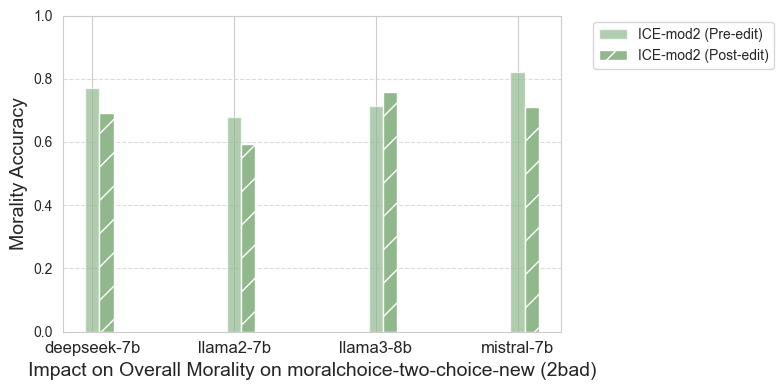

In [5]:
# Create a bar plot to visualize the accuracy before and after editing
def plot_moral_impact(df, results_dir, steer_direction='2bad'):
    eval_data_name = results_dir.split('/')[-1]
    plt.figure(figsize=(8, 4))
    sns.set_style("whitegrid")

    models = df['model'].unique()
    edit_methods = df['edit_method'].unique()
    x = np.arange(len(models))
    width = 0.15  # width of the bars
    
    # spacing between model groups
    model_spacing = 1.5
    
    for i, method in enumerate(edit_methods):
        method_data = df[df['edit_method'] == method]
        
        # Sort method_data to match the order of models
        method_data = method_data.set_index('model').loc[models].reset_index()
        
        # Position bars for each method
        method_offset = (i - len(edit_methods)/2 + 0.5) * width * 2.0
        
        # Place pre-edit and post-edit bars side by side
        plt.bar(x * model_spacing + method_offset, 
                method_data['acc_pre'].values / 100,  # Convert percentage to decimal
                width=width, alpha=0.7, 
                label=f'{method} (Pre-edit)', 
                color=colors[i])
        
        # Plot post-edit accuracy right next to pre-edit
        plt.bar(x * model_spacing + method_offset + width, 
                method_data['acc_post'].values / 100,  # Convert percentage to decimal
                width=width, alpha=1.0,
                label=f'{method} (Post-edit)', 
                color=colors[i], hatch='/')
    
    plt.ylabel('Morality Accuracy', fontsize=14)
    plt.ylim(0, 1.0)
    plt.xticks(x * model_spacing, models, fontsize=12)
    plt.xlabel(f'Impact on Overall Morality on {eval_data_name} ({steer_direction})', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # plt.legend(bbox_to_anchor=(0.5, 1.05), loc='upper center', ncol=len(edit_methods)*2)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


df = moral_impact_res("../results/impact/moralchoice-two-choice-new")
# ICE-mod use each question's target in the context, ICE-mod2 only use edit_indices from the target
plot_moral_impact(df, "../results/impact/moralchoice-two-choice-new")

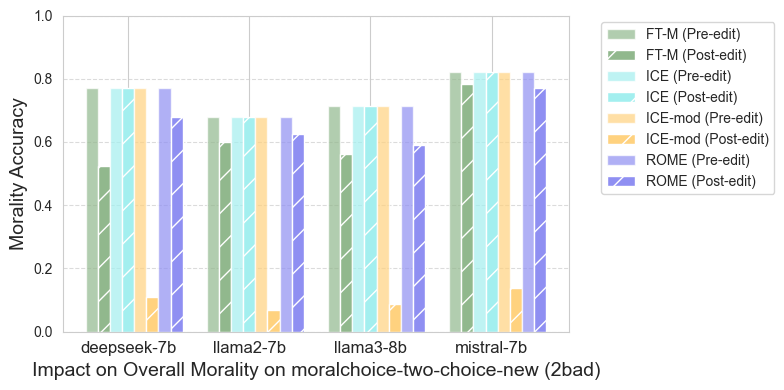

In [27]:
df = moral_impact_res("../results/impact/moralchoice-two-choice")
# Update the accuracy value for deepseek-7b ICE method
mask = (df['model'] == 'deepseek-7b') & (df['edit_method'] == 'ICE')
df.loc[mask, 'acc_post'] = 76.92
plot_moral_impact(df, "../results/impact/moralchoice-two-choice")

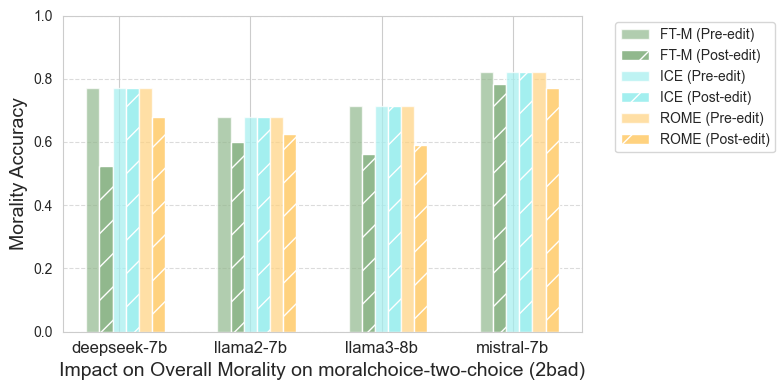

In [ ]:
plot_moral_impact(df, "../results/impact/moralchoice-two-choice")

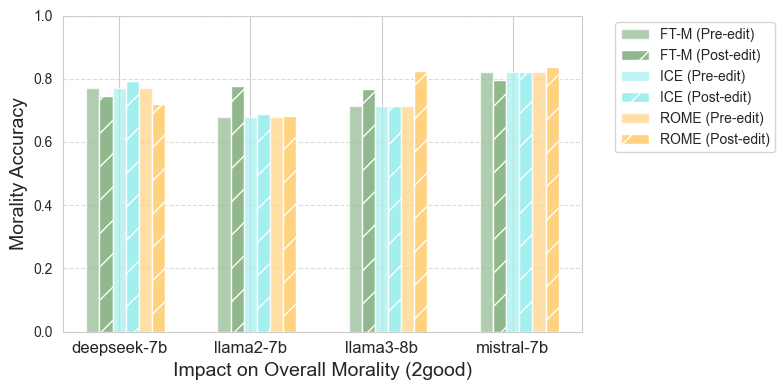

In [46]:
plot_moral_impact(moral_impact_res("../results/impact/moralchoice-two-choice-2good", '2good'), '2good')

bar plot where x-axis has 3 models, each model have 3 group (with 3 edit_method), and within each edit_method, put pre-edit and post-edit accuracy bar side by side, so each model should have 6 bars, use edit_method as hue, and show pre and post-edit score with 2 bar pattern to differentiate

## Other

2 datasets x 7 edit methods x 4 models

In [4]:
summarize_results("../results/in_domain/llama3-8b")

,domain,topic,edit_method,efficacy_pre,efficacy_post
0,moralchoice,ROME to bad,None,1.88,80.97
1,moralchoice,ROME to good,None,1.83,84.68


In [5]:
summarize_results("../results/in_domain/mistral-7b")

,domain,topic,edit_method,efficacy_pre,efficacy_post
0,moralchoice,ROME to bad,None,1.88,91.39
1,moralchoice,ROME to good,None,1.29,93.74


In [6]:
# efficacy_pre of vanilla is low, often output '\nPlease select one of the options'
summarize_results("../results/in_domain/llama2-7b")

,domain,topic,edit_method,efficacy_pre,efficacy_post
0,moralchoice,ROME to bad,None,1.81,98.04
1,moralchoice,ROME to good,None,1.99,97.19


In [ ]:
# Try use the similar prompt in moralchoice_gpt, because the pre-edit responses of moralchoice_gpt are not good (repeat the question etc.).

In [5]:
df_llama3.groupby(['domain', 'edit_method']).mean().reset_index()

,domain,edit_method,efficacy_pre,efficacy_post,rephrase_pre,rephrase_post,yes_pre,yes_post,no_pre,no_post,mc_pre,mc_post,reversed_pre,reversed_post,locality_post
0,art,FT-L,0.0,47.000000,12.000000,59.000000,61.000000,46.000000,26.000000,10.000000,34.00,33.000000,6.000000,0.000000,16.000000
1,art,FT-M,0.0,77.000000,12.000000,74.000000,61.000000,61.000000,26.000000,23.000000,34.00,33.000000,6.000000,2.000000,53.000000
2,art,GRACE,0.0,99.000000,12.000000,3.000000,61.000000,10.000000,26.000000,15.000000,34.00,2.000000,6.000000,1.000000,26.000000
3,art,ICE,0.0,90.000000,12.000000,87.000000,61.000000,87.000000,26.000000,65.000000,34.00,81.000000,6.000000,72.000000,50.000000
4,art,LoRA,0.0,88.000000,12.000000,86.000000,61.000000,63.000000,26.000000,25.000000,34.00,54.000000,6.000000,4.000000,30.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,technology,GRACE,0.0,99.666667,10.513333,2.813333,70.390000,20.723333,29.423333,20.723333,32.34,2.480000,9.626667,1.740000,38.796667
59,technology,ICE,0.0,96.706667,10.513333,92.820000,70.390000,91.226667,29.423333,78.090000,32.34,91.300000,9.626667,70.023333,65.503333
60,technology,LoRA,0.0,91.050000,10.513333,90.123333,70.390000,72.763333,29.423333,22.023333,32.34,63.876667,9.626667,7.960000,33.090000
61,technology,MEMIT,0.0,75.210000,10.513333,73.210000,70.390000,83.463333,29.423333,24.276667,32.34,65.950000,9.626667,8.700000,23.903333


In [6]:
column_ls = ['domain', 'edit_method', 'efficacy_post', 'locality_post']
df_llama3[column_ls].groupby(['domain', 'edit_method']).mean().mean().reset_index(name='overall')

,index,overall
0,efficacy_post,79.594921
1,locality_post,37.594550


In [7]:
df_llama2['model'] = 'Llama2-7B'
df_llama3['model'] = 'Llama3-8B'
df_mistral['model'] = 'Mistral-v0.3-7B'
df_combined = pd.concat([df_llama2, df_llama3, df_mistral])
df_combined_grouped = df_combined.groupby(['model', 'edit_method']).mean().reset_index()
df_combined_grouped['Avg Generalization Scores Pre'] = df_combined_grouped[['rephrase_pre', 'yes_pre', 'no_pre', 'mc_pre', 'reversed_pre']].mean(axis=1)
df_combined_grouped['Avg Generalization Scores Post'] = df_combined_grouped[['rephrase_post', 'yes_post', 'no_post', 'mc_post', 'reversed_post']].mean(axis=1)
df_combined_grouped[['model', 'edit_method', 'Avg Generalization Scores Pre', 'Avg Generalization Scores Post']]

,model,edit_method,Avg Generalization Scores Pre,Avg Generalization Scores Post
0,Llama2-7B,FT-L,35.139385,42.697308
1,Llama2-7B,FT-M,35.139385,42.877538
2,Llama2-7B,GRACE,35.139385,0.520692
3,Llama2-7B,ICE,35.139385,77.858154
4,Llama2-7B,LoRA,35.139385,47.484462
5,Llama2-7B,MEMIT,35.139385,49.981846
6,Llama2-7B,ROME,35.154769,50.924615
7,Llama3-8B,FT-L,31.888000,30.153923
8,Llama3-8B,FT-M,31.888000,40.305692
9,Llama3-8B,GRACE,31.888000,7.981077


In [8]:
df_multi_hop_llama3

,edit_method,domain,topic,questions_2hop_pre,questions_2hop_post,questions_3hop_pre,questions_3hop_post,questions_4hop_pre,questions_4hop_post,questions_5hop_pre,questions_5hop_post,questions_6hop_pre,questions_6hop_post
0,FT-L,art,sculpture,23.00,11.00,29.00,15.00,22.00,16.00,32.00,20.00,29.00,26.00
1,FT-L,business,brand,26.00,11.00,22.00,7.00,21.00,13.00,19.00,16.00,29.00,16.00
2,FT-L,business,corporation,20.00,5.56,22.22,4.44,17.78,13.33,17.78,11.11,22.22,10.00
3,FT-L,business,industry,42.86,7.14,47.96,16.33,23.47,12.24,26.53,11.22,26.53,14.29
4,FT-L,entertainment,anime,15.00,6.00,17.00,4.00,14.00,12.00,20.00,14.00,23.00,16.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,GRACE,places,country,32.00,1.00,25.00,0.00,25.00,1.00,27.00,2.00,32.00,1.00
178,GRACE,places,landmark,32.00,2.00,31.00,3.00,23.00,3.00,28.00,2.00,32.00,0.00
179,GRACE,technology,database,23.17,1.22,20.73,1.22,15.85,0.00,21.95,2.44,30.49,0.00
180,GRACE,technology,programming language,24.00,0.00,18.00,0.00,11.00,0.00,13.00,0.00,17.00,0.00


In [9]:
df_multi_hop_llama3.groupby(['domain', 'edit_method']).mean().mean().reset_index(name='overall')

,index,overall
0,questions_2hop_pre,26.992593
1,questions_2hop_post,22.969101
2,questions_3hop_pre,24.172222
3,questions_3hop_post,18.510265
4,questions_4hop_pre,20.677778
5,questions_4hop_post,18.418254
6,questions_5hop_pre,25.261111
7,questions_5hop_post,21.370582
8,questions_6hop_pre,26.931111
9,questions_6hop_post,22.092275


In [10]:
# robustness evaluation
def summarize_multi_turn_overall(folder_paths):
    data_list = []
    for folder_path in folder_paths:
        for filename in os.listdir(folder_path):
            if filename.endswith('.json'):
                parts = filename.split('_')
                domain = parts[0]
                topic = ' '.join(parts[1:-2])  
                edit_method = parts[-2]
                type_ = parts[-1].replace('.json', '')

                file_path = os.path.join(folder_path, filename)
                with open(file_path, 'r') as file:
                    metrics = json.load(file)
                
                multi_turn_ls_post = [e['post']['edit_acc_multi_turn'] for e in metrics]
                
                post_mean = np.mean(multi_turn_ls_post, axis=0)
                
                for turn, post in enumerate(post_mean):
                    data_list.append({
                        'model': os.path.basename(folder_path),
                        'domain': domain,
                        'topic': topic,
                        'edit_method': edit_method,
                        'type': type_,
                        'turn': turn,
                        'robustness score': post
                    })
    
    return pd.DataFrame(data_list)

folder_paths_multi_turn = [
    '../results/hallu_edit_multi_turn/llama_2_7b_chat_hf_multi_turn',
    '../results/hallu_edit_multi_turn/meta_llama_3_8b_instruct_multi_turn',
    '../results/hallu_edit_multi_turn/mistral_7b_instruct_v0.3_multi_turn',
]
df_multi_turn = summarize_multi_turn_overall(folder_paths_multi_turn)
df_multi_turn

,model,domain,topic,edit_method,type,turn,robustness score
0,llama_2_7b_chat_hf_multi_turn,entertainment,music genre,FT-L,yes,0,0.690000
1,llama_2_7b_chat_hf_multi_turn,entertainment,music genre,FT-L,yes,1,0.410000
2,llama_2_7b_chat_hf_multi_turn,entertainment,music genre,FT-L,yes,2,0.560000
3,llama_2_7b_chat_hf_multi_turn,entertainment,music genre,FT-L,yes,3,0.330000
4,llama_2_7b_chat_hf_multi_turn,entertainment,music genre,FT-L,yes,4,0.280000
...,...,...,...,...,...,...,...
6001,mistral_7b_instruct_v0.3_multi_turn,health,medication,LoRA,yes,6,0.433333
6002,mistral_7b_instruct_v0.3_multi_turn,health,medication,LoRA,yes,7,0.466667
6003,mistral_7b_instruct_v0.3_multi_turn,health,medication,LoRA,yes,8,0.466667
6004,mistral_7b_instruct_v0.3_multi_turn,health,medication,LoRA,yes,9,0.466667


In [11]:
df_multi_turn.groupby(['model', 'edit_method', 'turn']).mean()


robustness score
model                               edit_method turn                  
llama_2_7b_chat_hf_multi_turn       FT-L        0             0.669753
                                                1             0.355590
                                                2             0.362630
                                                3             0.229536
                                                4             0.205715
...                                                                ...
mistral_7b_instruct_v0.3_multi_turn ROME        6             0.740984
                                                7             0.740984
                                                8             0.740984
                                                9             0.740984
                                                10            0.740984

[231 rows x 1 columns]